In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
from tqdm import tqdm

from src.common import load_data, prepare_train_data, generate_submission

In [3]:
# Configuration
MODEL_PATH = "models/mlp_baseline.pth"
EPOCHS = 20
BATCH_SIZE = 256
LR = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#
class MLP(nn.Module):
    def __init__(self, input_dim=1024, output_dim=1536, hidden_dim=2048):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, output_dim),
        )

    def forward(self, x):
        return self.net(x)

In [4]:
import torch.nn.functional as F

def train_model(model, train_loader, val_loader, device, epochs, lr):
    """Train the MLP model"""
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float('inf')

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)

            loss = F.mse_loss(outputs, y_batch)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = F.mse_loss(outputs, y_batch)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.6f}, Val Loss = {val_loss:.6f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            Path(MODEL_PATH).parent.mkdir(parents=True, exist_ok=True)
            torch.save(model.state_dict(), MODEL_PATH)
            print(f"  ✓ Saved best model (val_loss={val_loss:.6f})")

    return model


In [5]:
# Load data
train_data = load_data("data/train/train.npz")
X, y, label = prepare_train_data(train_data)
DATASET_SIZE = len(X)
# Split train/val
# This is done only to measure generalization capabilities, you don't have to
# use a validation set (though we encourage this)
n_train = int(0.9 * len(X))
TRAIN_SPLIT = torch.zeros(len(X), dtype=torch.bool)
TRAIN_SPLIT[:n_train] = 1
X_train, X_val = X[TRAIN_SPLIT], X[~TRAIN_SPLIT]
y_train, y_val = y[TRAIN_SPLIT], y[~TRAIN_SPLIT]


train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
y_train.shape[-1], X_val.shape[-1]

(125000,)
Train data: 125000 captions, 125000 images


(1536, 1024)

In [6]:
model = MLP().to(DEVICE)
print(f"   Parameters: {sum(p.numel() for p in model.parameters()):,}")

# Train
print("\n3. Training...")
model = train_model(model, train_loader, val_loader, DEVICE, 1, LR)

# Load best model for evaluation
model.load_state_dict(torch.load(MODEL_PATH))


   Parameters: 1,574,400

3. Training...


Epoch 1/1: 100%|██████████| 440/440 [00:01<00:00, 284.72it/s]


Epoch 1: Train Loss = 0.171852, Val Loss = 0.158206
  ✓ Saved best model (val_loss=0.158206)


<All keys matched successfully>

## Evaluation

### Visualize

/root/aml_challenge/src/eval/visualize.py:27: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4416.)
  similarities = (image_embeddings @ pred_embeddings.T).squeeze().numpy()


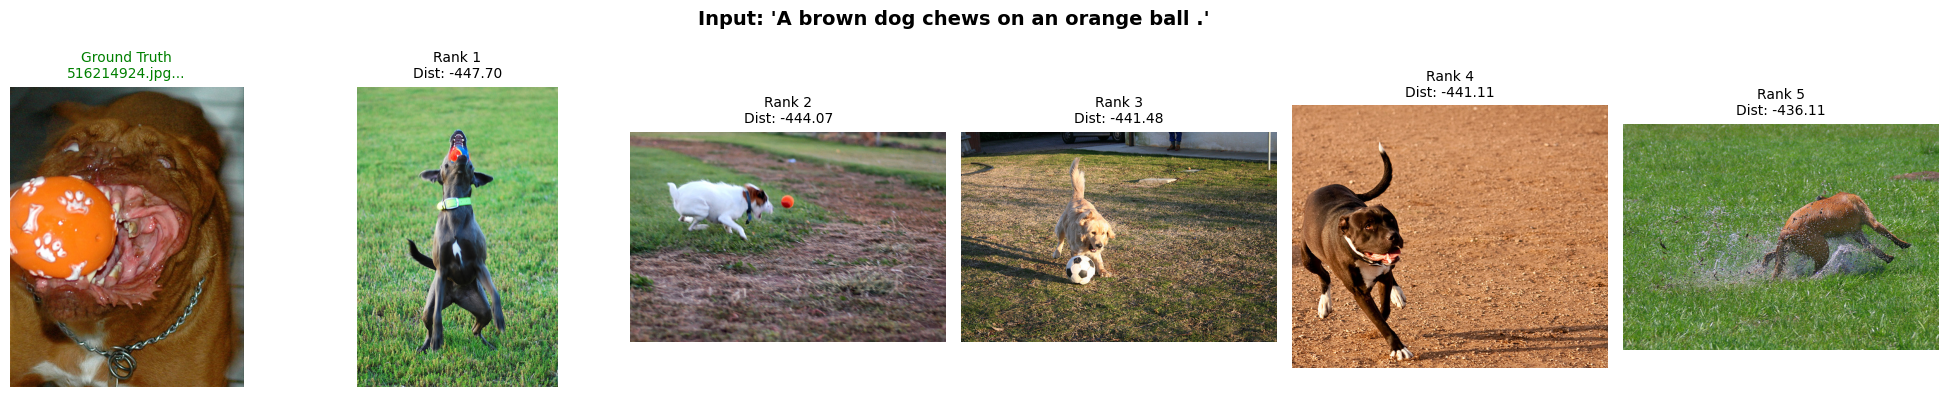

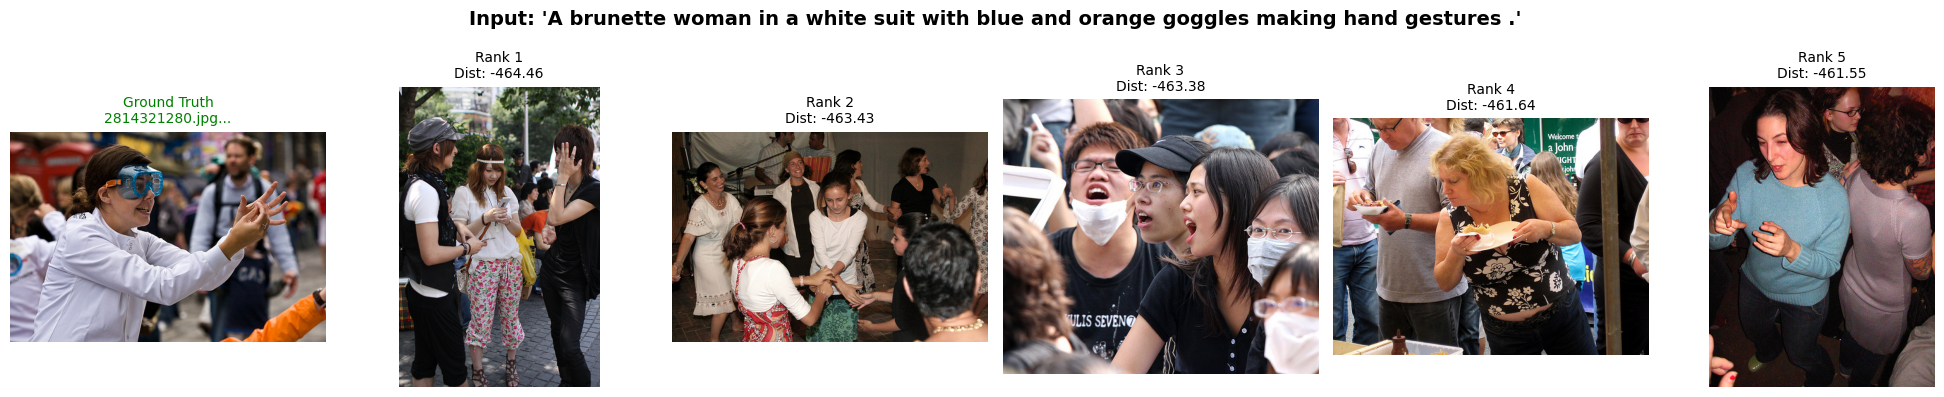

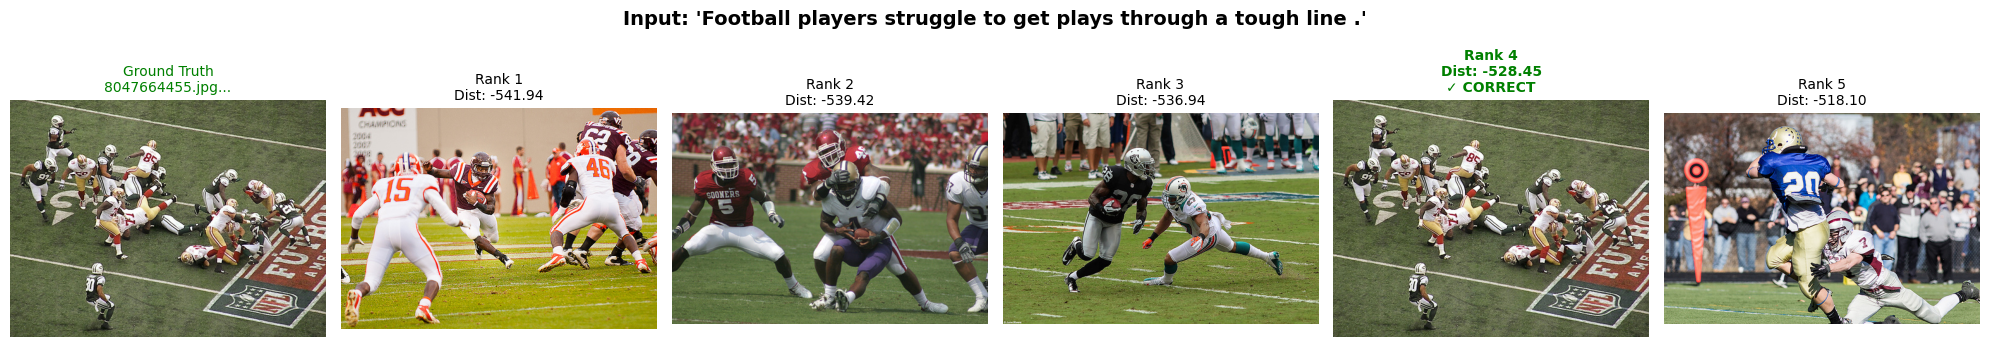

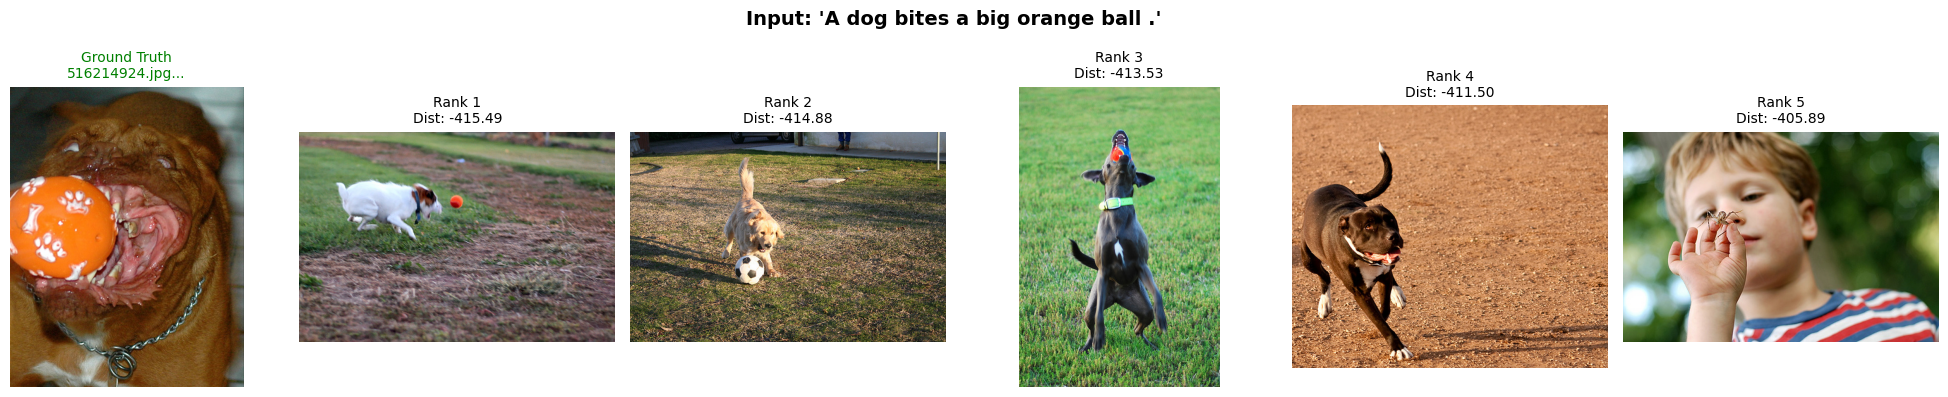

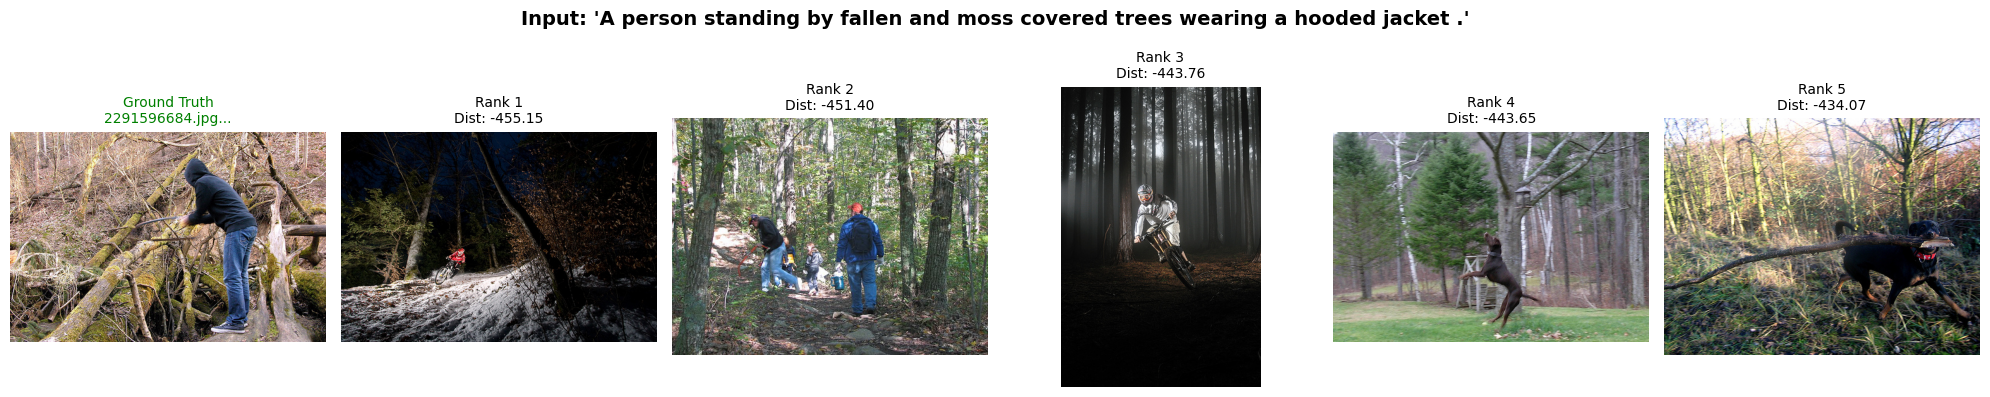

In [ ]:
from src.eval import visualize_retrieval
import numpy as np
import torch

val_caption_text = train_data['captions/text'][~TRAIN_SPLIT]
val_text_embd = X_val
img_VAL_SPLIT = label[~TRAIN_SPLIT].sum(dim=0) > 0
val_img_file = train_data['images/names'][img_VAL_SPLIT]
val_img_embd = torch.from_numpy(train_data['images/embeddings'][img_VAL_SPLIT])
val_label = np.nonzero(train_data['captions/label'][~TRAIN_SPLIT][:,img_VAL_SPLIT])[1]

# Sample and visualize
for i in range(5):
    idx = np.random.randint(0, 100)
    caption_embd = val_text_embd[idx]
    caption_text = val_caption_text[idx]
    gt_index = val_label[idx]

    with torch.no_grad():
        pred_embds = model(caption_embd.to(DEVICE)).cpu()

        visualize_retrieval(
            pred_embds,
            gt_index,
            val_img_file,
            caption_text, val_img_embd, k=5)

## Submission

In [12]:
test_data = load_data("data/test/test.clean.npz")

test_embds = test_data['captions/embeddings']
test_embds = torch.from_numpy(test_embds).float()

with torch.no_grad():
    pred_embds = model(test_embds.to(DEVICE)).cpu()

submission = generate_submission(test_data['captions/ids'], pred_embds, 'submission.csv')
print(f"Model saved to: {MODEL_PATH}")

Generating submission file...
✓ Saved submission to submission.csv
Model saved to: models/mlp_baseline.pth
